# Neural Network Weight Optimization - Emotion Detection
Replay the same problem from assignment 1 with neural network weight optimization by randomized optimization

Reference: https://mlrose.readthedocs.io/en/stable/source/tutorial3.html

## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import time

## Load data

In [2]:
data = pd.read_csv('data/emotion-detection/icml_face_data.csv/icml_face_data.csv')
data = data.rename(columns={' Usage': 'Usage', ' pixels': 'pixels'})  # Somehow column names conatin a leading space

## Set aside a test set and sample train set

In [3]:
# Set aside a test set
full_train_set = data[data['Usage']=='Training']
test_set = data[data['Usage']=='PrivateTest']
print(len(full_train_set), 'total train istances +', len(test_set), 'test instances')
# To reduce training time, further sample train set in a stratified way
train_set, _ = train_test_split(full_train_set, test_size=0.95, random_state=0, stratify=full_train_set['emotion'])
print(len(train_set), 'sampled train istances for training (to save training time)')

28709 total train istances + 3589 test instances
1435 sampled train istances for training (to save training time)


## Prepare the data for model training

In [4]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_name].str.strip('"').str.split(pat=' ', expand=True).values

pipeline = Pipeline([
    ('selector', DataFrameSelector('pixels')),
    ('std_scaler', StandardScaler()),
])

train_X = pipeline.fit_transform(train_set)
train_y = np.array(train_set['emotion'])

# One hot encode labels
one_hot = OneHotEncoder()
one_hot_train_y = one_hot.fit_transform(train_y.reshape(-1, 1)).todense()

## Optimize Neural Network weights by randomized optimization

In [5]:
# Construct neural network model and specify optimizer
algorithm = 'gradient_descent'  # CHNAGE ALGORITHM HERE
algorithm_specific_parameters = {
    'gradient_descent': {
        'max_iters': 100,
        'max_attempts': 10,
    },
    'random_hill_climb': {
        'max_iters': 1000,
        'max_attempts': 100,
        'restarts': 5,
    },
    'simulated_annealing': {
        'max_iters': 10000,
        'max_attempts': 100,
        'schedule': mlrose.ExpDecay(),
    },
    'genetic_alg': {
        'max_iters': 100,
        'max_attempts': 10,
        'pop_size': 200,
        'mutation_prob': 0.4,
    },
}
nn = mlrose.NeuralNetwork(
    # Common parameters
    algorithm=algorithm,
    hidden_nodes=[512],  # Besides hidden nodes, num of input nodes = 2304 and num of output nodes = 7
    activation='relu',
    bias=True,
    is_classifier=True,
    learning_rate=0.0001,
    early_stopping=True,
    clip_max=5,
    random_state=0,
    curve=True,
    # Parameters specific to algorithm
    **algorithm_specific_parameters[algorithm]
)

In [6]:
# Fit to learn weights
start_time = time.time()
nn.fit(train_X, one_hot_train_y)
end_time = time.time()
print('Time elapsed (in seconds): {}'.format(end_time - start_time))
print('Minimized log loss (negative of fitness): {}'.format(np.min(-nn.fitness_curve)))

Time elapsed (in seconds): 31.177410125732422
Minimized log loss (negative of fitness): 7.350652169090731


In [7]:
# Predict and evaluate on train set
pred_y = nn.predict(train_X)
print('Train accuracy: {}'.format(accuracy_score(one_hot_train_y, pred_y)))

Train accuracy: 0.7407665505226481


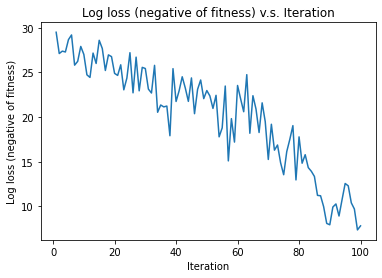

In [8]:
# Plot fitness curve
def plot_fitness_curve(fitness_curve):
    iters = list(range(1, len(fitness_curve) + 1))
    plt.plot(iters, fitness_curve)
    plt.title('Log loss (negative of fitness) v.s. Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Log loss (negative of fitness)')
    plt.show()
    
plot_fitness_curve(-nn.fitness_curve)  # Note: mlrose derives fitness by flipping the sign of log loss

## Evaluate the model on the test set

In [9]:
# Predict and evaluate on test set
test_X = pipeline.transform(test_set)
test_y = np.array(test_set['emotion'])
one_hot_test_y = one_hot.transform(test_y.reshape(-1, 1)).todense()
pred_y = nn.predict(test_X)
print('Test accuracy: {}'.format(accuracy_score(one_hot_test_y, pred_y)))

Test accuracy: 0.2750069657286152


## Plot train/test accuracy v.s. log loss (negative of fitness)

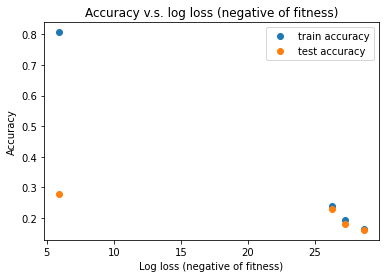

In [10]:
labels = ['Gradient Descent', 'Random Hill Climbing', 'Simulated Annealing', 'Genetic Algorithm']
log_losses = [5.9288, 27.2341, 28.6343, 26.2833]
train_accuracies = [0.8070, 0.1923, 0.1624, 0.2383]
test_accuracies = [0.2784, 0.1814, 0.1610, 0.2279]

plt.plot(log_losses, train_accuracies, label='train accuracy', marker='o', linestyle = 'None')
plt.plot(log_losses, test_accuracies, label='test accuracy', marker='o', linestyle = 'None')
plt.title('Accuracy v.s. log loss (negative of fitness)')
plt.xlabel('Log loss (negative of fitness)')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')